In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
import os
import cv2 as cv
import numpy as np


# Carga de la data a clasificar

Para el caso a desarrollar vamos a trabajar con la data **natural images**, la misma esta conformada por 8 clases:
<li> airplane
<li> car
<li> cat
<li> dog
<li> flower
<li> fruit
<li> motorbike
<li> person

La solucion que se busca para este problema es la clasificación utilizando una red convolucional.

# Exploración preliminar de la data

Para ello definimos una función que nos permita tomar una muestra del dataset y graficarla

In [ ]:
def display_random_images_folder(root_path, samples_per_folder=5):
    """
    Muestra imagenes aleatorias de cada clase, considerando que .

    Parameters:
    - root_path: Ruta, La ruta al directorio raíz que contiene la información.
    - samples_per_folder: Númoro de muestras a mostrar por cada subcarpeta/clase (default is 5).
    """

    labels = os.listdir(root_path)

    fig = plt.figure(figsize=(20, 15))

    for row_index in range(len(labels)):
        subdirectory = str(row_index + 1)
        folder_path =os.path.join(root_path, labels[row_index])

        if os.path.isdir(folder_path):  # Check if the path is a directory
            images = os.listdir(folder_path)
            for sample_index in range(samples_per_folder):
                if images:  # Ensure there are images to sample
                    random_number = random.randint(0, len(images) - 1)
                    image_path = os.path.join(folder_path, images[random_number])
                    image = cv.imread(image_path)

                    ax = fig.add_subplot(len(labels), samples_per_folder, samples_per_folder * row_index + sample_index + 1)
                    ax.axis("off")
                    ax.set_title(str(labels[row_index]))
                    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()

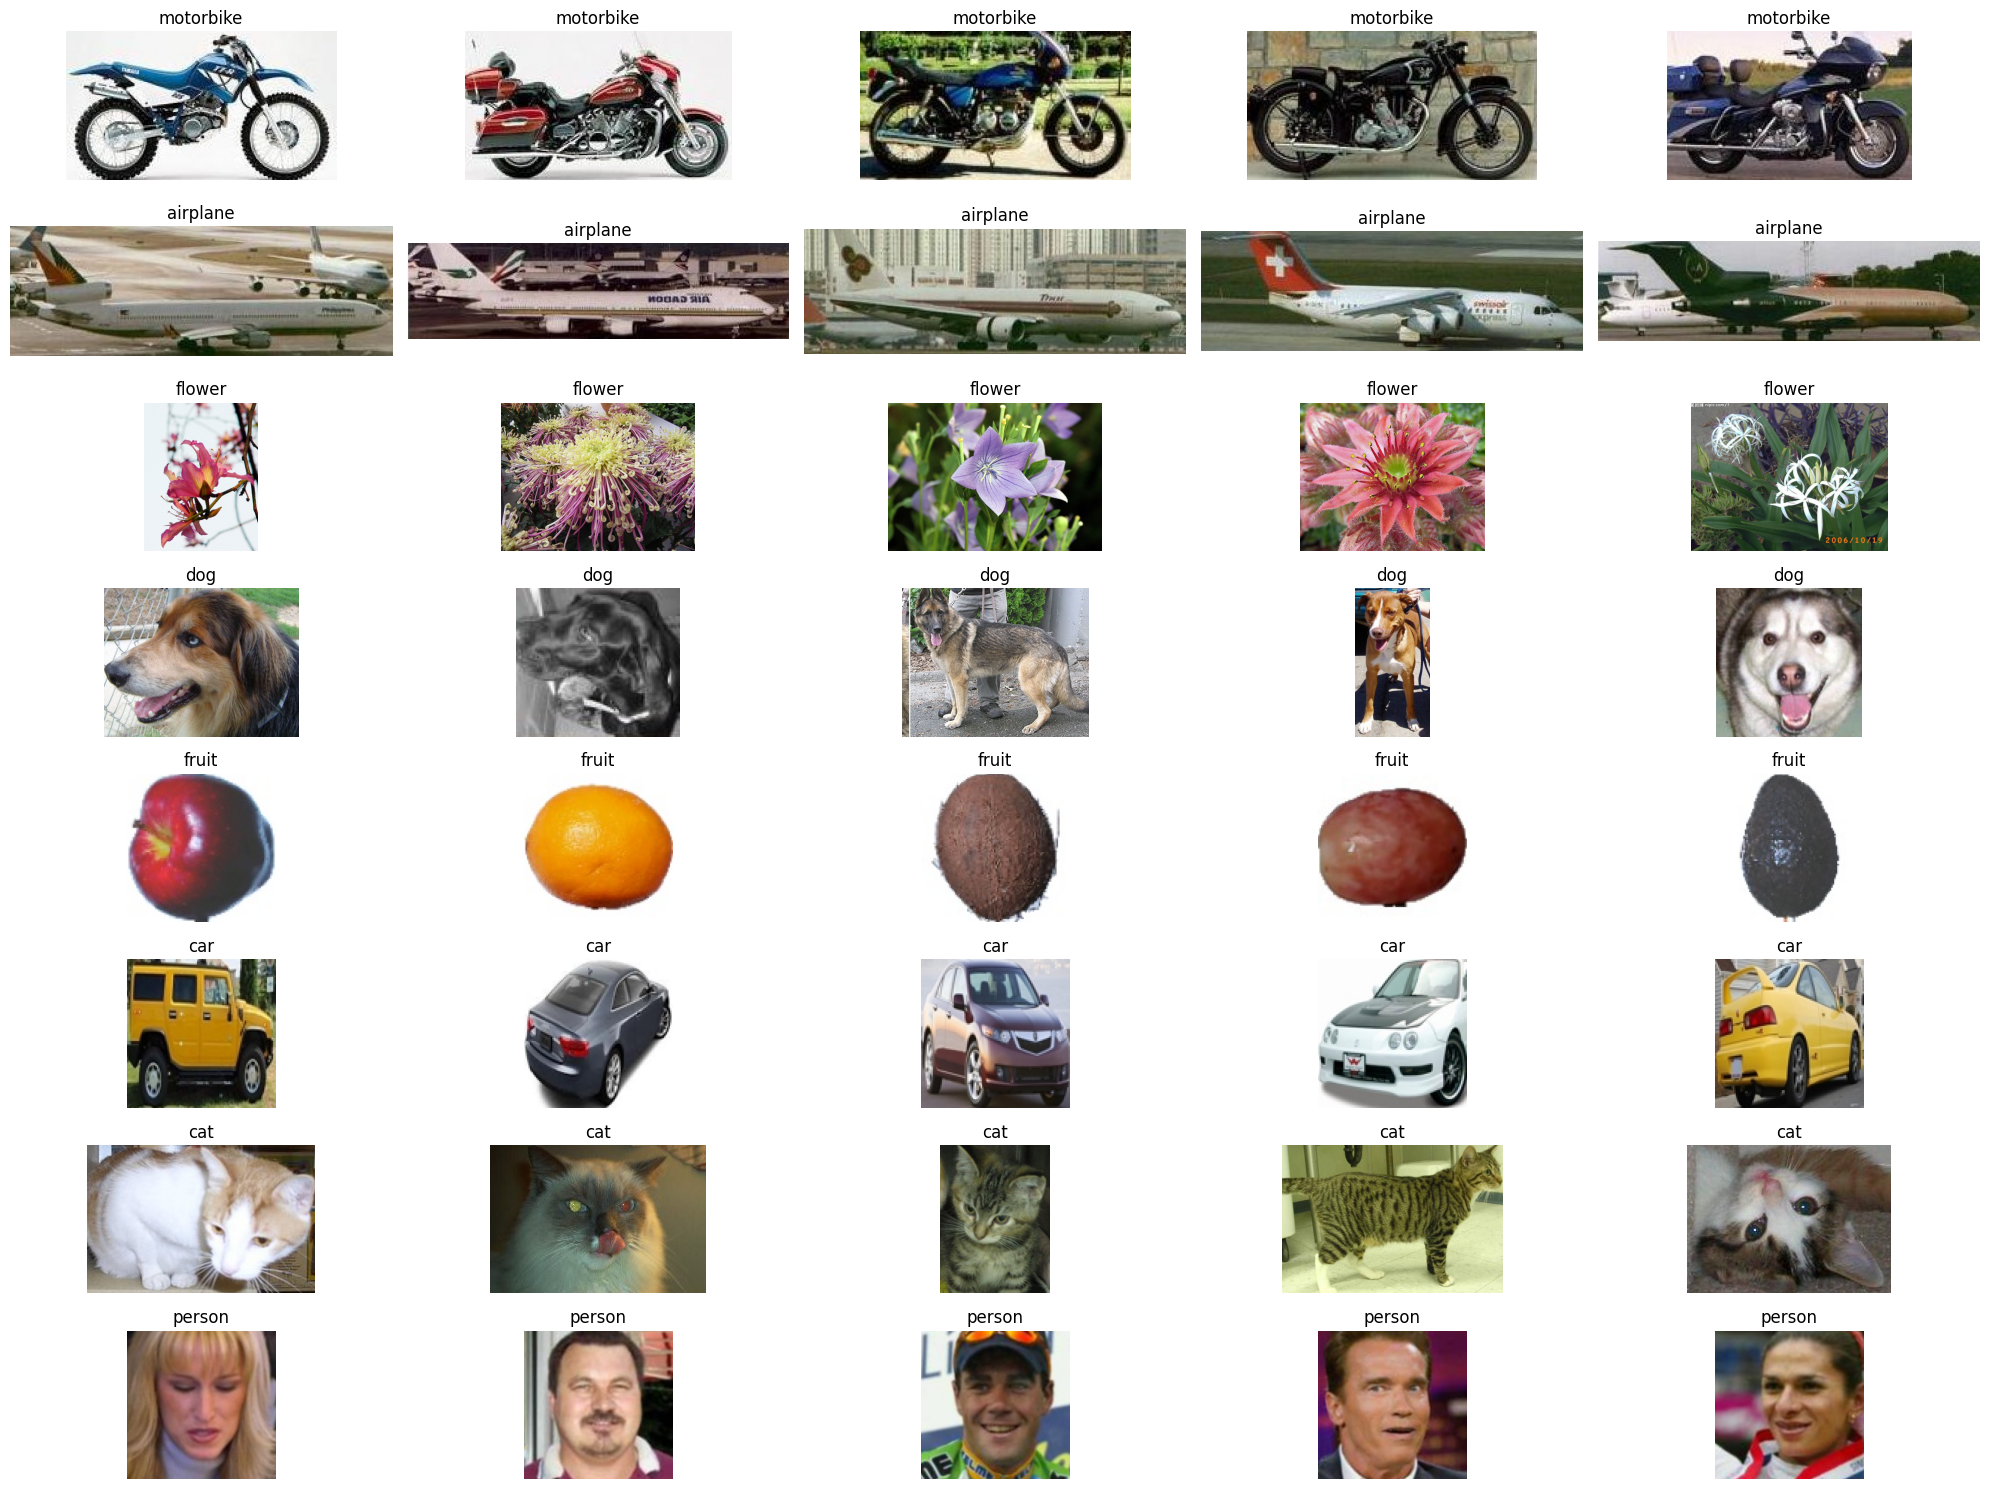

In [ ]:
root_path = r"/kaggle/input/natural-images/natural_images"
# Ploteo de la muestra
display_random_images_folder(root_path)

Es posible evidenciar que existe una disparidad de dimensiones que debemos considerar.

Definimos una función que grafique como estan distribuidas las dimensiones por clase

In [ ]:
def get_image_sizes_by_class(root_path):
    class_sizes = {}
    supported_extensions = ('.png', '.jpg', '.jpeg')  # Extensiones soportadas
    total_images = 0
    valid_images = 0

    for root, dirs, files in os.walk(root_path):
        class_name = os.path.basename(root)
        if files:
            class_sizes[class_name] = []
        for file in files:
            if file.lower().endswith(supported_extensions):
                total_images += 1
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        class_sizes[class_name].append(img.size)
                        valid_images += 1
                except Exception as e:
                    print(f"Error al abrir la imagen {file_path}: {e}")

    print(f"Total de imágenes encontradas: {total_images}")
    print(f"Imágenes válidas procesadas: {valid_images}")
    print(f"Imágenes no válidas o con errores: {total_images - valid_images}")

    return class_sizes

Total de imágenes encontradas: 6899
Imágenes válidas procesadas: 6899
Imágenes no válidas o con errores: 0


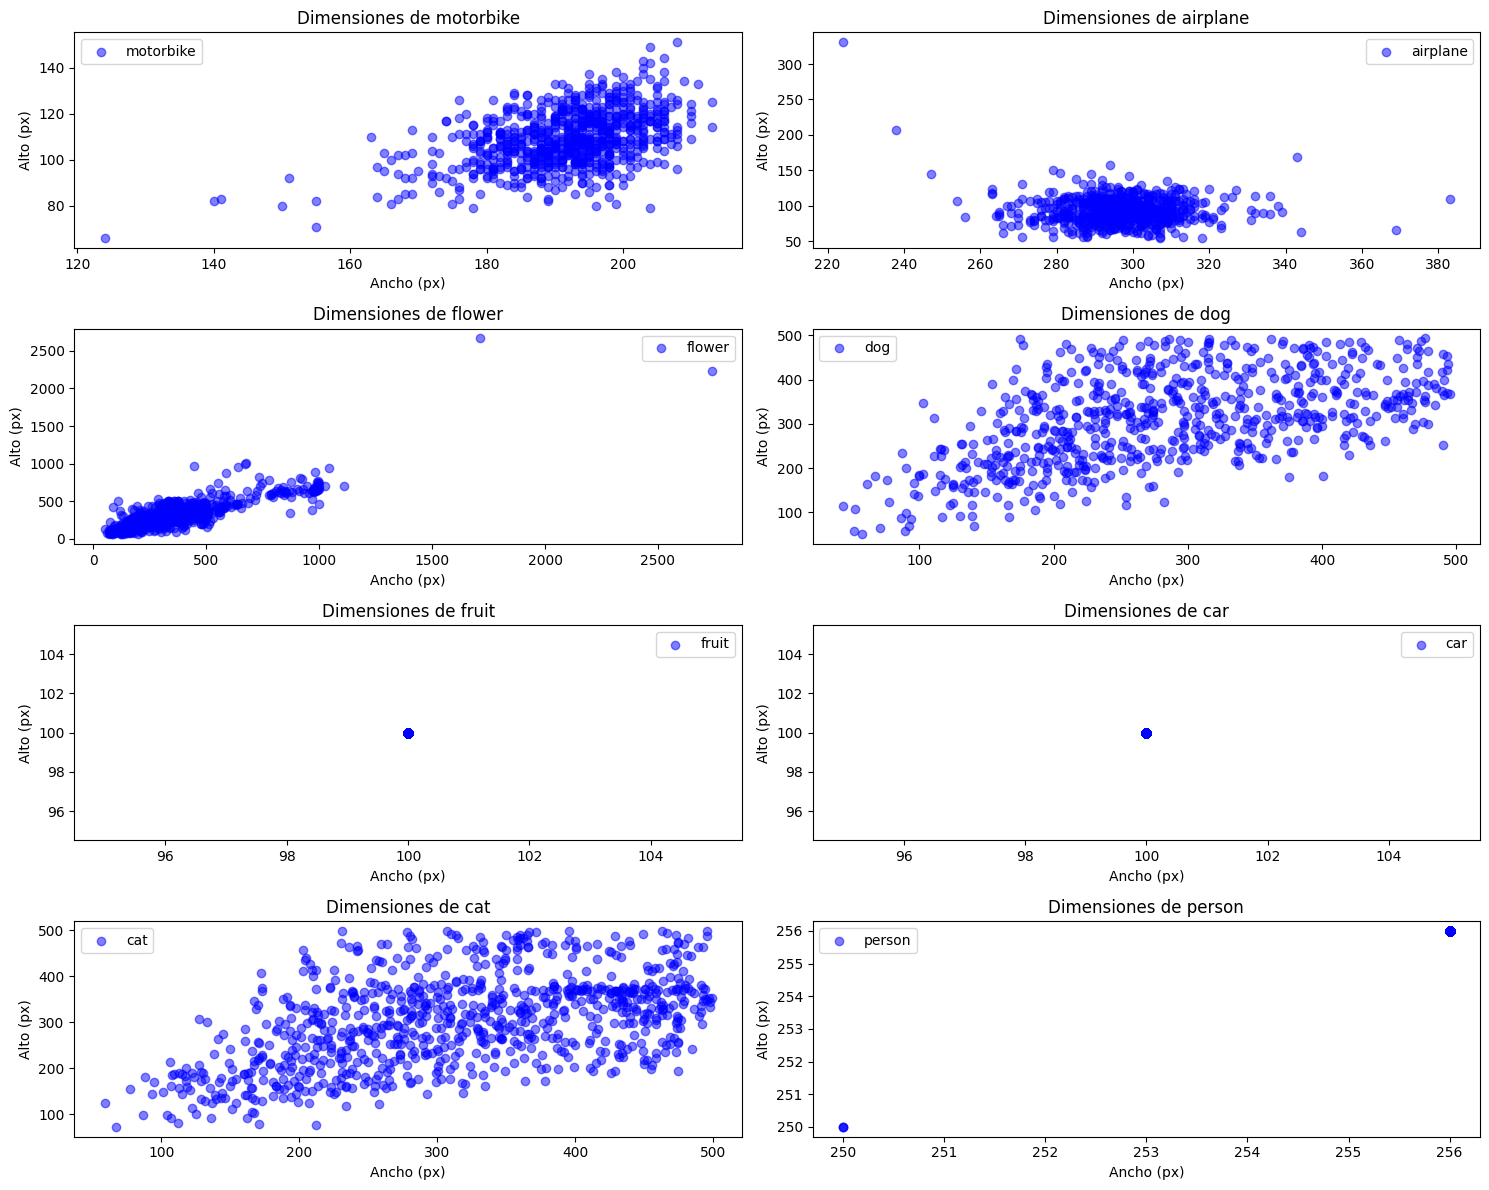

In [ ]:
class_sizes = get_image_sizes_by_class(root_path)

# Graficar scatterplots de dimensiones por clase
if class_sizes:
    num_classes = len(class_sizes)
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (class_name, sizes) in enumerate(class_sizes.items()):
        #Verificar que haya imágenes en la clase
        if sizes:
            widths, heights = zip(*sizes)

            axes[i].scatter(widths, heights, alpha=0.5, label=f'{class_name}', color='b')
            axes[i].set_title(f'Dimensiones de {class_name}')
            axes[i].set_xlabel('Ancho (px)')
            axes[i].set_ylabel('Alto (px)')
            axes[i].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes válidas para procesar.")

Se desprende de este gráfico que la distribución de dimensiones es bastante heterogenea.

La clase **airplane** muestra dimension de ancho variando entre 220 y 380 (aprox) y la de alto entre 50 y 320 (aprox)

La clase **car** tiene una dimension 100x100

La clase **cat** muestra dimension de ancho variando entre 60 y 500 (aprox) y la de alto entre 60 y 500 (aprox)

La clase **dog** muestra dimension de ancho variando entre 60 y 500 (aprox) y la de alto entre 60 y 500 (aprox)

La clase **flower** muestra dimension de ancho variando entre 50 y 1000 (aprox) y la de alto entre 50 y 1000 (aprox)

La clase **fruit** tiene una dimension 100x100

La clase **motorbike** muestra dimension de ancho variando entre 120 y 256 (aprox) y la de alto entre 20 y 160

La clase **person** tiene una dimensión 250x250 o 256x256

Por lo que es importante considerar en la solución un óptimo uso del resize para que nuestro modelo recoja correctamente las características.


# Validación del nivel de balance del dataset

In [ ]:
# Cargar el dataset
dataset = torchvision.datasets.ImageFolder(root=root_path)

# Verificar la distribución de las clases
class_counts = torch.bincount(torch.tensor(dataset.targets))
print(f'Distribución original de clases: {class_counts}')

Distribución original de clases: tensor([ 727,  968,  885,  702,  843, 1000,  788,  986])


Es notorio que las clases no se encuentran del todo balanceadas, por lo que sería necesario realizar alguna técnica de balanceo, en particular se plantea realizar un WeightedRadonsomSampling para corregir este desbalance.

In [ ]:
def get_loaders(root_path, batch_size, test_size=0.2, random_seed=42):
    """
    Crea DataLoaders balanceados para entrenamiento y no balanceados para prueba.

    Args:
        root_path (str): Ruta al directorio del dataset.
        batch_size (int): Tamaño del batch para los DataLoaders.
        test_size (float, opcional): Proporción del dataset para el conjunto de prueba. Default es 0.2.
        random_seed (int, opcional): Semilla para la reproducibilidad. Default es 42.

    Returns:
        train_loader (DataLoader): DataLoader balanceado para entrenamiento.
        test_loader (DataLoader): DataLoader para prueba.
        class_counts_train (torch.Tensor): Conteo de clases en el conjunto de entrenamiento.
        class_counts_test (torch.Tensor): Conteo de clases en el conjunto de prueba.
    """

    # Definir transformaciones
    my_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.35),
        transforms.RandomVerticalFlip(p=0.35),
        transforms.ToTensor(),
    ])

    # Cargar el dataset completo
    full_dataset = datasets.ImageFolder(root=root_path, transform=my_transforms)

    # Obtener todas las etiquetas
    targets = np.array(full_dataset.targets)

    # Dividir índices en entrenamiento y prueba manteniendo la distribución de clases
    train_indices, test_indices = train_test_split(
        np.arange(len(targets)),
        test_size=test_size,
        stratify=targets,
        random_state=random_seed
    )

    # Crear subconjuntos para entrenamiento y prueba
    train_subset = Subset(full_dataset, train_indices)
    test_subset = Subset(full_dataset, test_indices)

    # Obtener las etiquetas de los subconjuntos
    train_targets = targets[train_indices]
    test_targets = targets[test_indices]

    # Calcular la distribución de clases en el conjunto de entrenamiento
    class_counts_train = torch.bincount(torch.tensor(train_targets))
    print(f'Distribución original de clases en entrenamiento: {class_counts_train}')

    # Calcular pesos
    class_weights = 1.0 / class_counts_train.float()

    # Normaliza los pesos para que la suma sea igual al número de clases
    class_weights = class_weights / class_weights.sum() * len(class_weights)

    # Asigna los pesos a cada muestra en el conjunto de entrenamiento
    sample_weights = [class_weights[label] for label in train_targets]
    sample_weights = torch.tensor(sample_weights, dtype=torch.float)

    # Crea el sampler ponderado
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Crea DataLoader para entrenamiento con sampler
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=4,
        pin_memory=True
    )

    # Crea DataLoader para prueba sin balanceo
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Calcular la distribución de clases en el conjunto de prueba
    class_counts_test = torch.bincount(torch.tensor(test_targets))
    print(f'Distribución original de clases en prueba: {class_counts_test}')

    return train_loader, test_loader, class_counts_train, class_counts_test

In [ ]:
batch_size = 8
test_size = 0.2


train_loader, test_loader, class_counts_train, class_counts_test = get_loaders(
        root_path=root_path,
        batch_size=batch_size,
        test_size=test_size,
        random_seed=42
    )

    # Verificar la distribución en el DataLoader balanceado de entrenamiento
balanced_counts_train = [0] * len(class_counts_train)
for data, labels in train_loader:
    for label in labels:
        balanced_counts_train[label] += 1

print(f'Distribución en el DataLoader de entrenamiento balanceado: {balanced_counts_train}')

    # Verificar la distribución en el DataLoader de prueba
balanced_counts_test = [0] * len(class_counts_test)
for data, labels in test_loader:
    for label in labels:
        balanced_counts_test[label] += 1

print(f'Distribución en el DataLoader de prueba: {balanced_counts_test}')

Distribución original de clases en entrenamiento: tensor([582, 774, 708, 562, 674, 800, 630, 789])
Distribución original de clases en prueba: tensor([145, 194, 177, 140, 169, 200, 158, 197])
Distribución en el DataLoader de entrenamiento balanceado: [711, 661, 696, 679, 733, 683, 661, 695]
Distribución en el DataLoader de prueba: [145, 194, 177, 140, 169, 200, 158, 197]


# Visualización luego de las transformaciones

In [ ]:
def plot_class_samples(train_loader, num_samples=4):
    # Obtener todas las clases únicas
    all_classes = train_loader.dataset.dataset.classes
    num_classes = len(all_classes)

    # Crear un diccionario para almacenar las imágenes de cada clase
    class_images = {cls: [] for cls in range(num_classes)}

    # Recopilar imágenes de cada clase
    for images, labels in train_loader:
        for img, lbl in zip(images, labels):
            if len(class_images[lbl.item()]) < num_samples:
                class_images[lbl.item()].append(img)

        # Verificar si tenemos suficientes imágenes de cada clase
        if all(len(imgs) >= num_samples for imgs in class_images.values()):
            break

    # Configurar el plot
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 3*num_classes))
    fig.suptitle("Muestras de cada clase", fontsize=16)

    # Plotear las imágenes
    for i, (cls, imgs) in enumerate(class_images.items()):
        for j, img in enumerate(imgs[:num_samples]):
            ax = axes[i, j] if num_classes > 1 else axes[j]
            img_np = img.permute(1, 2, 0).numpy()  # Cambiar de CxHxW a HxWxC
            ax.imshow(img_np)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"{all_classes[cls]}", fontsize=10)

    plt.tight_layout()
    plt.show()

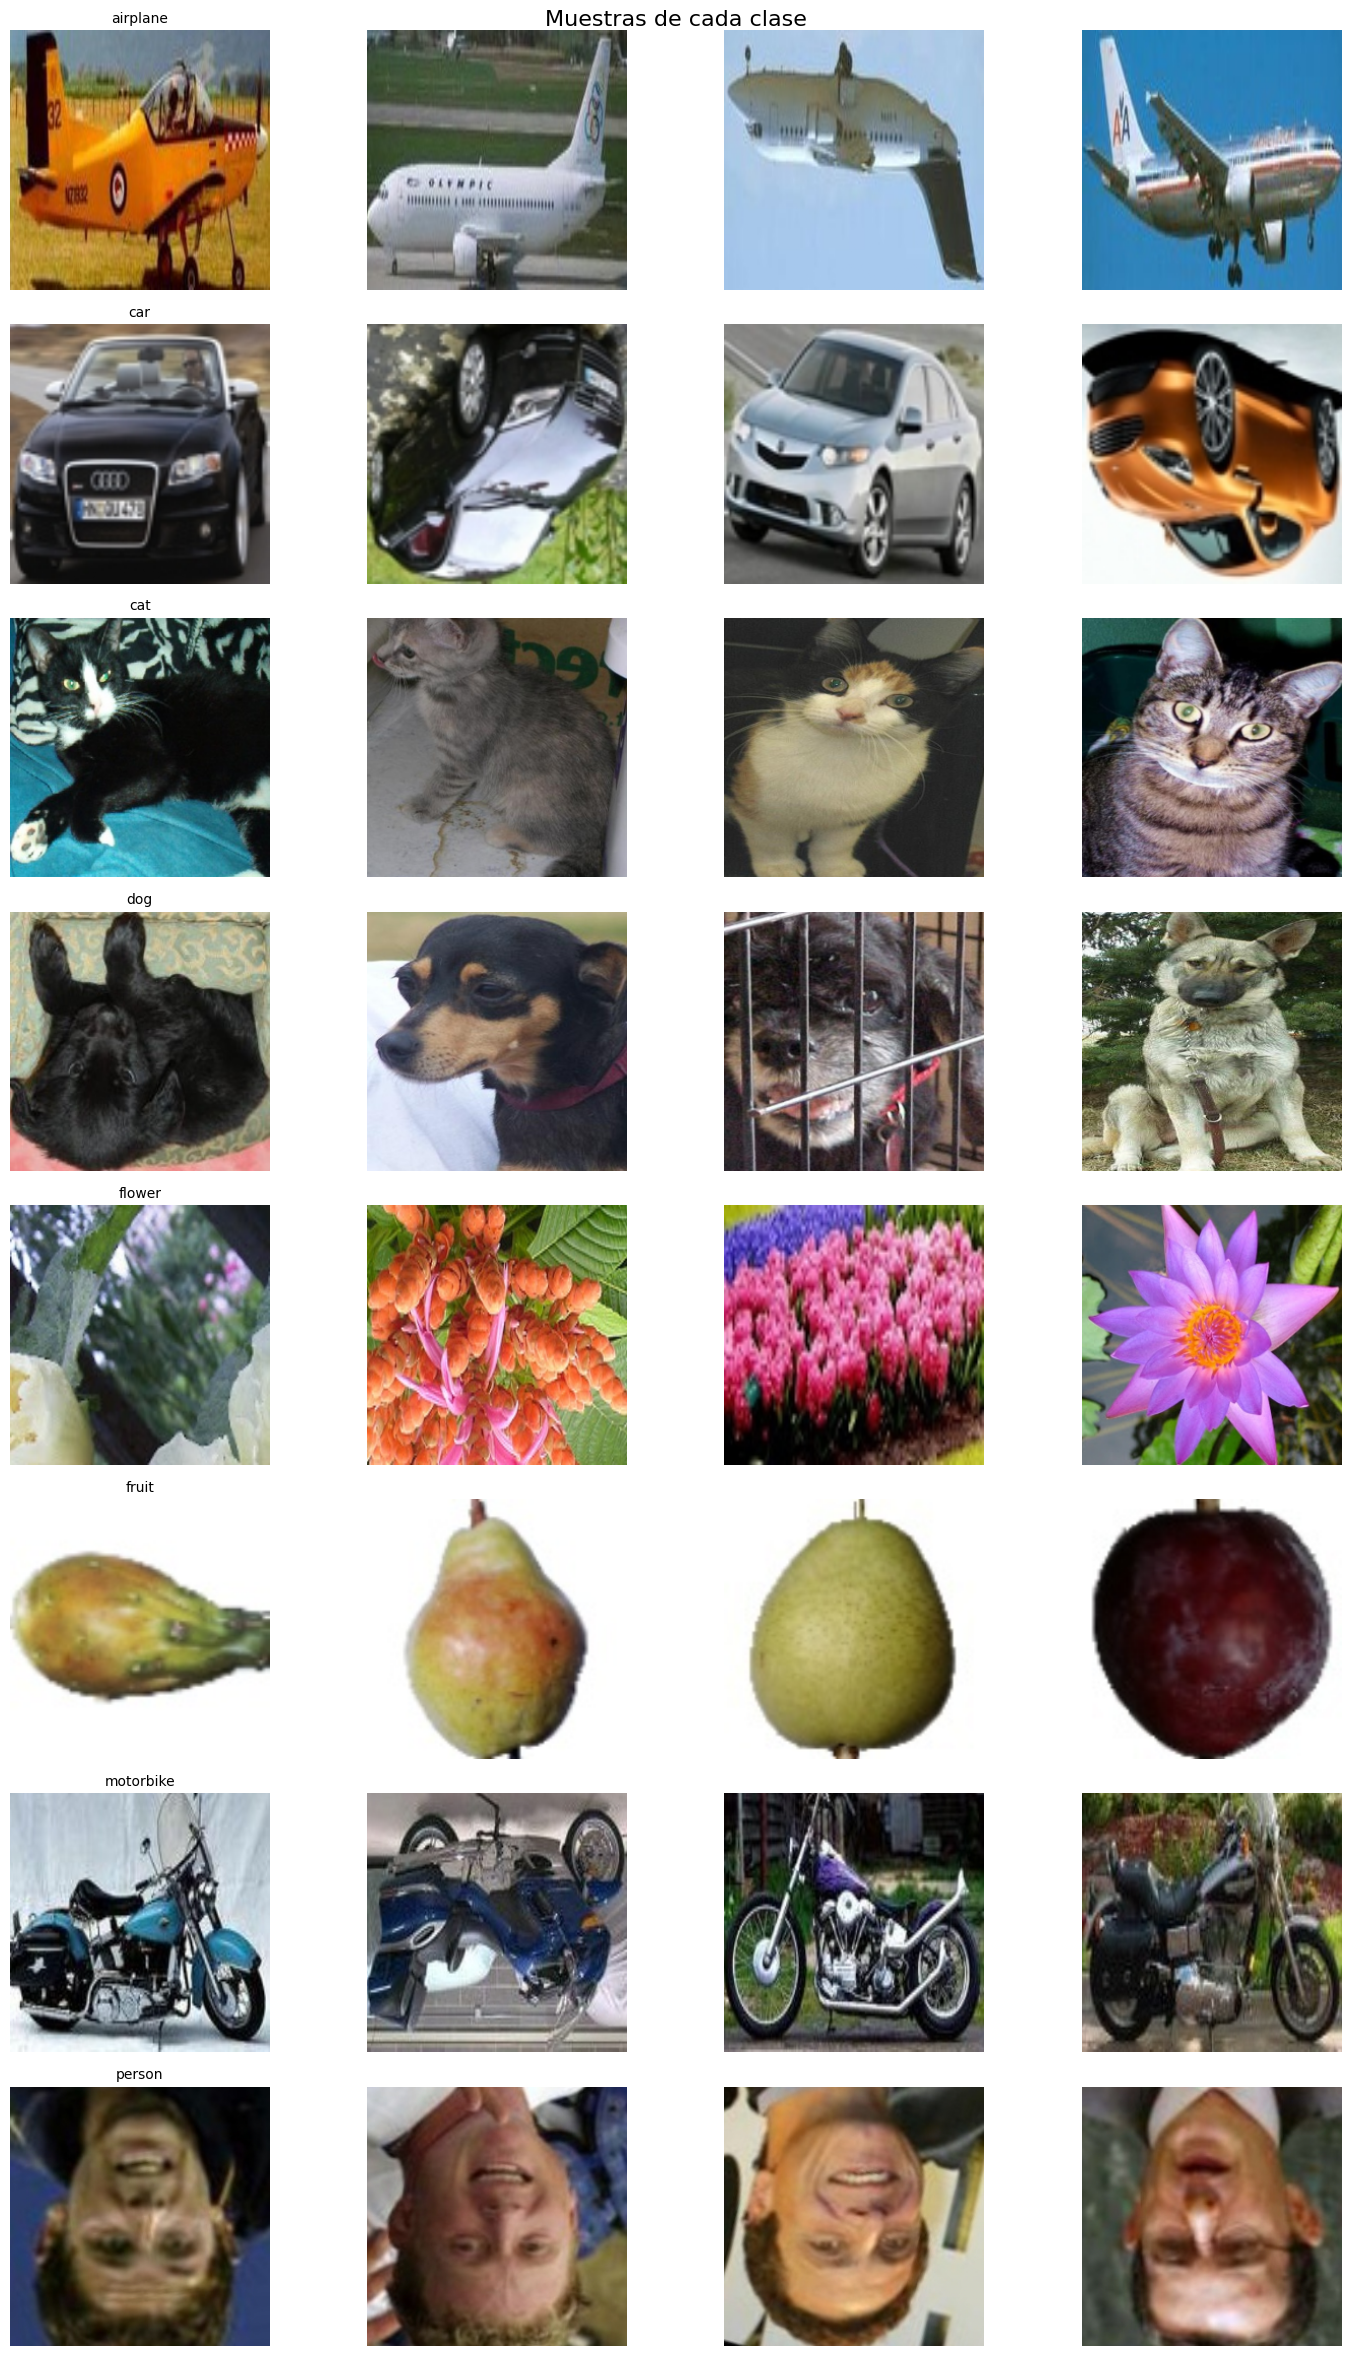

In [ ]:
plot_class_samples(train_loader)

La arquitectura planteada para la solución de este problema de clasificación viene definida por la siguiente estructura:
<li> 4 Capas convolucionales
<li> 4 Capas de BatchNormalization
<li> 2 Capas lineales densas

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.ReLU()(self.bn4(self.conv4(x)))

        x = self.pool(x)  # Adaptive pooling
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)

        return x

# Función para entrenamiento

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=1, device='cpu'):
    """
    Función para el entrenamineto del modelo
    """
    model.train()  # Asegurar que el modelo está en modo de entrenamiento
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return train_losses, train_accuracies


# Modificar la función de validación
def validate_model(model, val_loader, criterion, device='cpu'):
    model.eval()  # Cambiar al modo de evaluación
    val_losses = []
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0

    with torch.no_grad():  # No calcular gradientes
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())  # Almacenar etiquetas verdaderas
            all_predictions.extend(predicted.cpu().numpy())  # Almacenar predicciones
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = sum(val_losses) / len(val_losses)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy, all_labels, all_predictions

def save_model(model, prefix='', file_name='model.pth'):
    """Guarda los parámetros del modelo en un archivo con un prefijo.

    Args:
        model: El modelo a guardar.
        prefix: Prefijo para el nombre del archivo.
        file_name: Nombre del archivo base donde se guardarán los parámetros.
    """
    full_file_name = f"{prefix}_{file_name}" if prefix else file_name
    torch.save(model.state_dict(), full_file_name)
    print(f'Model saved to {full_file_name}')


In [ ]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Función que gráfica la evolución o performance del modelo en entrenamiento y validación
    """

    epochs = range(1, len(train_losses) + 1)

    # Graficar la pérdida
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Graficar la precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Gráfica de la matriz de confusión
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Configuración del device

In [ ]:
# Si existe GPU se utliza en caso contratio CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuraciones del modelo

In [ ]:
model = CustomCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    # Entrenamiento
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, num_epochs=1, device='cuda')
    train_losses.extend(train_loss)
    train_accuracies.extend(train_accuracy)

    # Validación
    validate_loss, validate_accuracy, labels, predictions = validate_model(model, test_loader, criterion, device='cuda')
    val_losses.append(validate_loss)
    val_accuracies.append(validate_accuracy)

    # Imprimir resultados de la validación
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {validate_loss:.4f}, Validation Accuracy: {validate_accuracy:.2f}%')

Epoch 1/20
Epoch [1], Loss: 1.1902, Accuracy: 55.54%
Validation Loss: 0.7991, Accuracy: 72.68%
Epoch [1/20], Validation Loss: 0.7991, Validation Accuracy: 72.68%
Epoch 2/20
Epoch [1], Loss: 0.8320, Accuracy: 69.40%
Validation Loss: 0.7275, Accuracy: 73.48%
Epoch [2/20], Validation Loss: 0.7275, Validation Accuracy: 73.48%
Epoch 3/20
Epoch [1], Loss: 0.6804, Accuracy: 74.47%
Validation Loss: 0.4571, Accuracy: 83.12%
Epoch [3/20], Validation Loss: 0.4571, Validation Accuracy: 83.12%
Epoch 4/20
Epoch [1], Loss: 0.5771, Accuracy: 78.09%
Validation Loss: 0.3964, Accuracy: 84.35%
Epoch [4/20], Validation Loss: 0.3964, Validation Accuracy: 84.35%
Epoch 5/20
Epoch [1], Loss: 0.5427, Accuracy: 78.95%
Validation Loss: 1.8868, Accuracy: 51.88%
Epoch [5/20], Validation Loss: 1.8868, Validation Accuracy: 51.88%
Epoch 6/20
Epoch [1], Loss: 0.4894, Accuracy: 80.23%
Validation Loss: 0.3493, Accuracy: 87.75%
Epoch [6/20], Validation Loss: 0.3493, Validation Accuracy: 87.75%
Epoch 7/20
Epoch [1], Loss: 

In [ ]:
save_model(model, prefix='256x256', file_name='modelo_entrenado.pth')

Model saved to 256x256_modelo_entrenado.pth


# Performance de entrenamiento y de validación

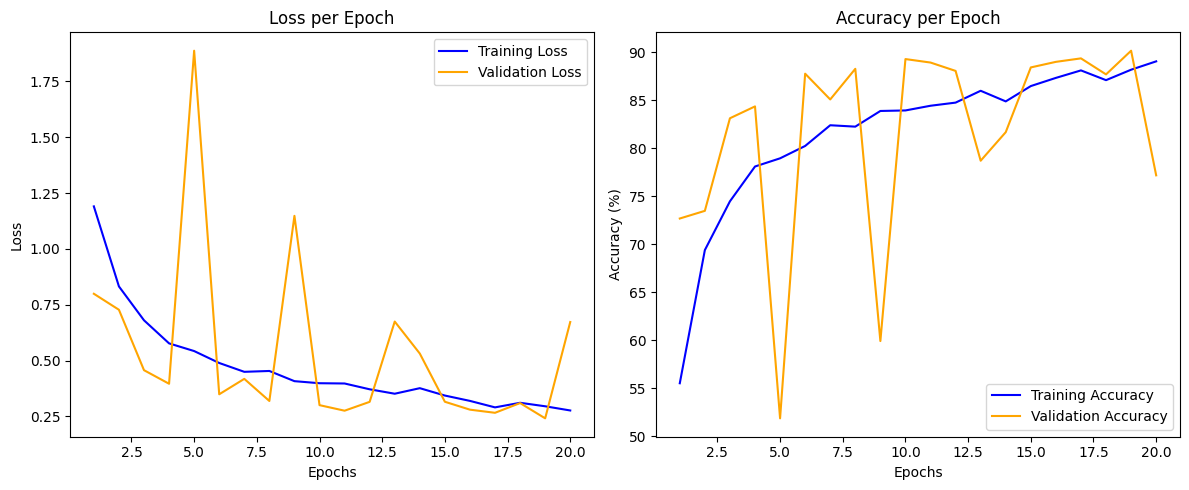

In [ ]:
# Graficar resultados
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# Matriz de confusión

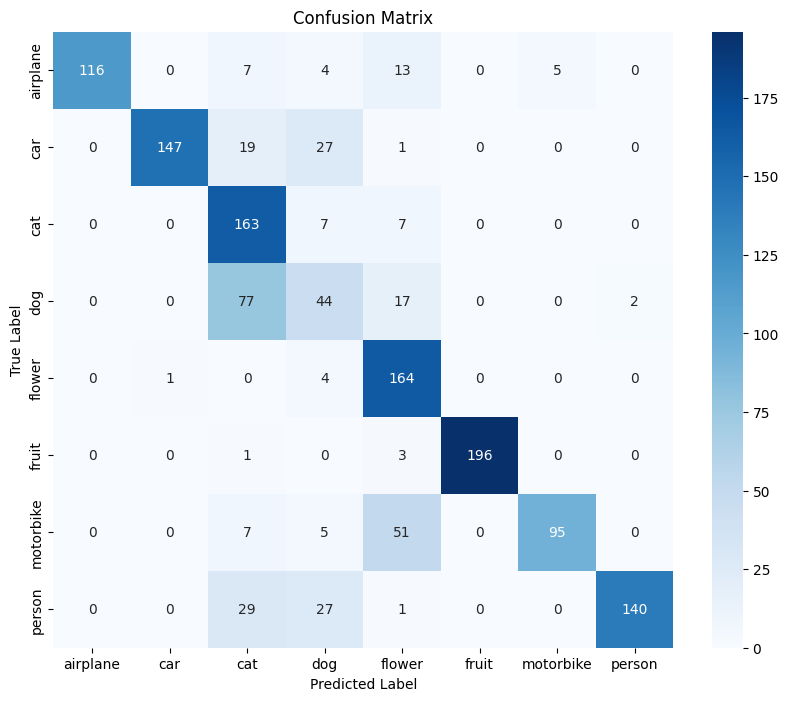

In [ ]:
classes = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
# Graficar matriz de confusión
plot_confusion_matrix(labels, predictions, classes)

# Transfer Learning

In [ ]:
import torchvision.models as models

In [ ]:
# Si existe GPU se utliza en caso contratio CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carga del modelo preentrenado
model_resten18 = models.resnet18(pretrained=True)
# Definición de las clases a clasificar

num_ftrs = model_resten18.fc.in_features
model_resten18.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
# congela los parametros
for param in model_resten18.parameters():
    param.requires_grad = False

In [ ]:
optimizer = optim.SGD(model_resten18.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Inicializa el dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mover el modelo al dispositivo
model_resten18.to(device)

# Inicializa las listas para almacenar las pérdidas y precisiones
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_labels = []
all_predictions = []

# Entrenamiento
for epoch in range(num_epochs):  # Define num_epochs
    model_resten18.train()  # Asegúrate de que el modelo está en modo de entrenamiento
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover a GPU
        optimizer.zero_grad()

        outputs = model_resten18(inputs)
        loss = criterion(outputs, labels)

        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los pesos

        running_loss += loss.item()

        # Calcular precisión
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Almacenar pérdida y precisión para el entrenamiento
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validación
    model_resten18.eval()  # Cambiar a modo de evaluación
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover a GPU
            outputs = model_resten18(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calcular la pérdida
            running_val_loss += loss.item()  # Sumar la pérdida de validación

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Almacenar etiquetas y predicciones
            all_labels.extend(labels.cpu().numpy())  # Mover a CPU
            all_predictions.extend(predicted.cpu().numpy())  # Mover a CPU

    # Almacenar pérdida y precisión para la validación
    avg_val_loss = running_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/20], Loss: 0.0009, Accuracy: 99.98%
Validation Loss: 0.0052, Validation Accuracy: 99.86%
Epoch [2/20], Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.0071, Validation Accuracy: 99.64%
Epoch [3/20], Loss: 0.0004, Accuracy: 100.00%
Validation Loss: 0.0084, Validation Accuracy: 99.71%
Epoch [4/20], Loss: 0.0007, Accuracy: 99.98%
Validation Loss: 0.0105, Validation Accuracy: 99.78%
Epoch [5/20], Loss: 0.0008, Accuracy: 99.98%
Validation Loss: 0.0080, Validation Accuracy: 99.57%
Epoch [6/20], Loss: 0.0015, Accuracy: 99.96%
Validation Loss: 0.0186, Validation Accuracy: 99.42%
Epoch [7/20], Loss: 0.0022, Accuracy: 99.91%
Validation Loss: 0.0044, Validation Accuracy: 99.78%
Epoch [8/20], Loss: 0.0008, Accuracy: 99.98%
Validation Loss: 0.0125, Validation Accuracy: 99.28%
Epoch [9/20], Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.0052, Validation Accuracy: 99.86%
Epoch [10/20], Loss: 0.0008, Accuracy: 99.98%
Validation Loss: 0.0090, Validation Accuracy: 99.64%
Epoch [11/20], L

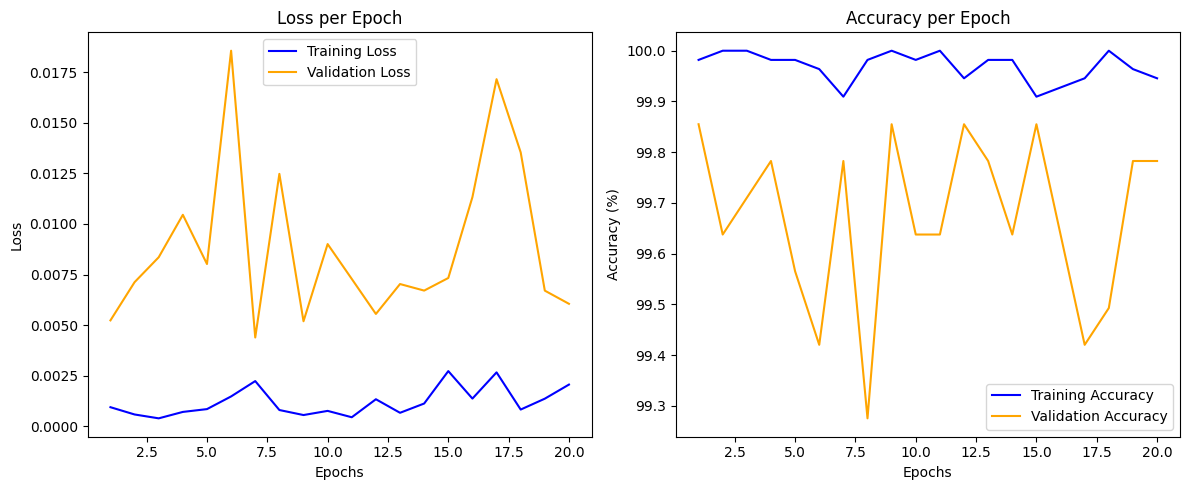

In [ ]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

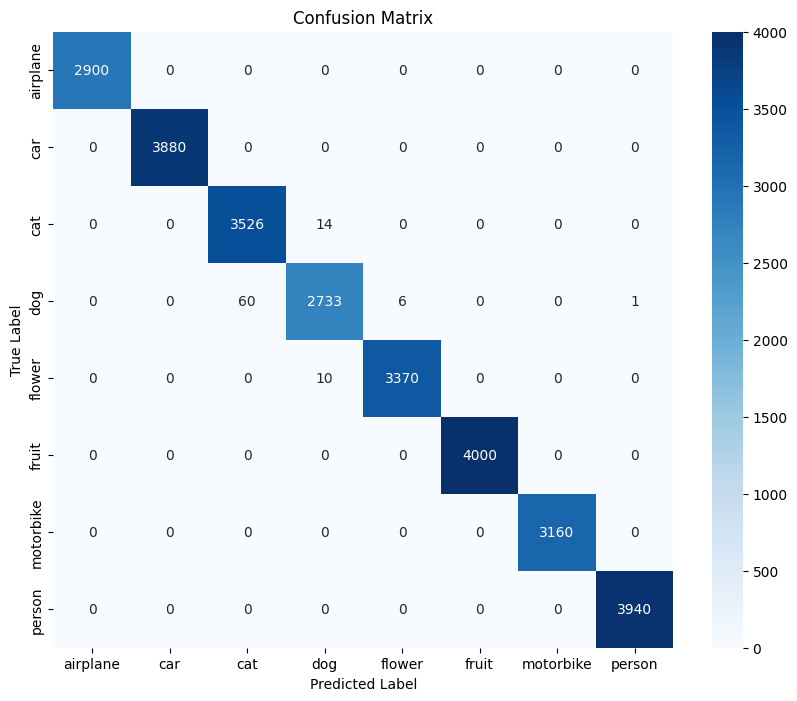

In [ ]:
# Graficar matriz de confusión
plot_confusion_matrix(all_labels, all_predictions, classes)